# watershed-workflow-3d.ipynb

This notebook demostrates how to watershed segmentation on CT data in three dimensions. 
Steps performed include:
- Load data
- Binarize images
- Perform 3D watershed segmentation
- Save segmented images

Note: `napari` is recommended to view the stack of images returned at each step in this process. If you are having trouble installing `napari` (there are known issues with the dependency `VisPy` on some new MacBooks), or if you would rather not use `napari`, `matplotlib.pyplot` can be used to view 2D slices instead. For this option, set `use_napari` in the cell below to `False` before importing packages.

In [1]:
# Set to False to use matplotlib.pyplot to view 2D images one at a time
use_napari = True

# Import packages

In [2]:
# Standard library imports
from pathlib import Path
# Third-party imports
import matplotlib.pyplot as plt
if use_napari:
    import napari
import numpy as np
from scipy import ndimage as ndi
import skimage
# Local module imports
import watershed
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

## Load, binarize, and segment 3D data

In [3]:
# Load images as 3D array from a directory containing images
imgs = watershed.load_images(
    'example-imgs', 
    return_3d_array=True,
    convert_to_float=True
)
print(f'Images loaded as 3D array: {imgs.shape}')
# Binarize raw images
binarize_3d_dict = watershed.binarize_3d(
    imgs, 
    thresh_val=0.65,
    fill_holes=64,
    return_process_dict=True
)
print(f'Images binarized. Process steps: {[key for key in binarize_3d_dict.keys()]}')
# Segment binary images with small holes filled
segment_3d_dict = watershed.segment_3d(
    binarize_3d_dict['holes-filled'],
    min_peak_distance=30,
    return_process_dict=True
)
print(f'Images segmented. Process steps: {[key for key in segment_3d_dict.keys()]}')

Images loaded as 3D array: (10, 1004, 924)
Images binarized. Process steps: ['binarized', 'holes-filled']
Images segmented. Process steps: ['distance-map', 'maxima-points', 'maxima-mask', 'seeds', 'integer-labels', 'colored-labels']


## Show process

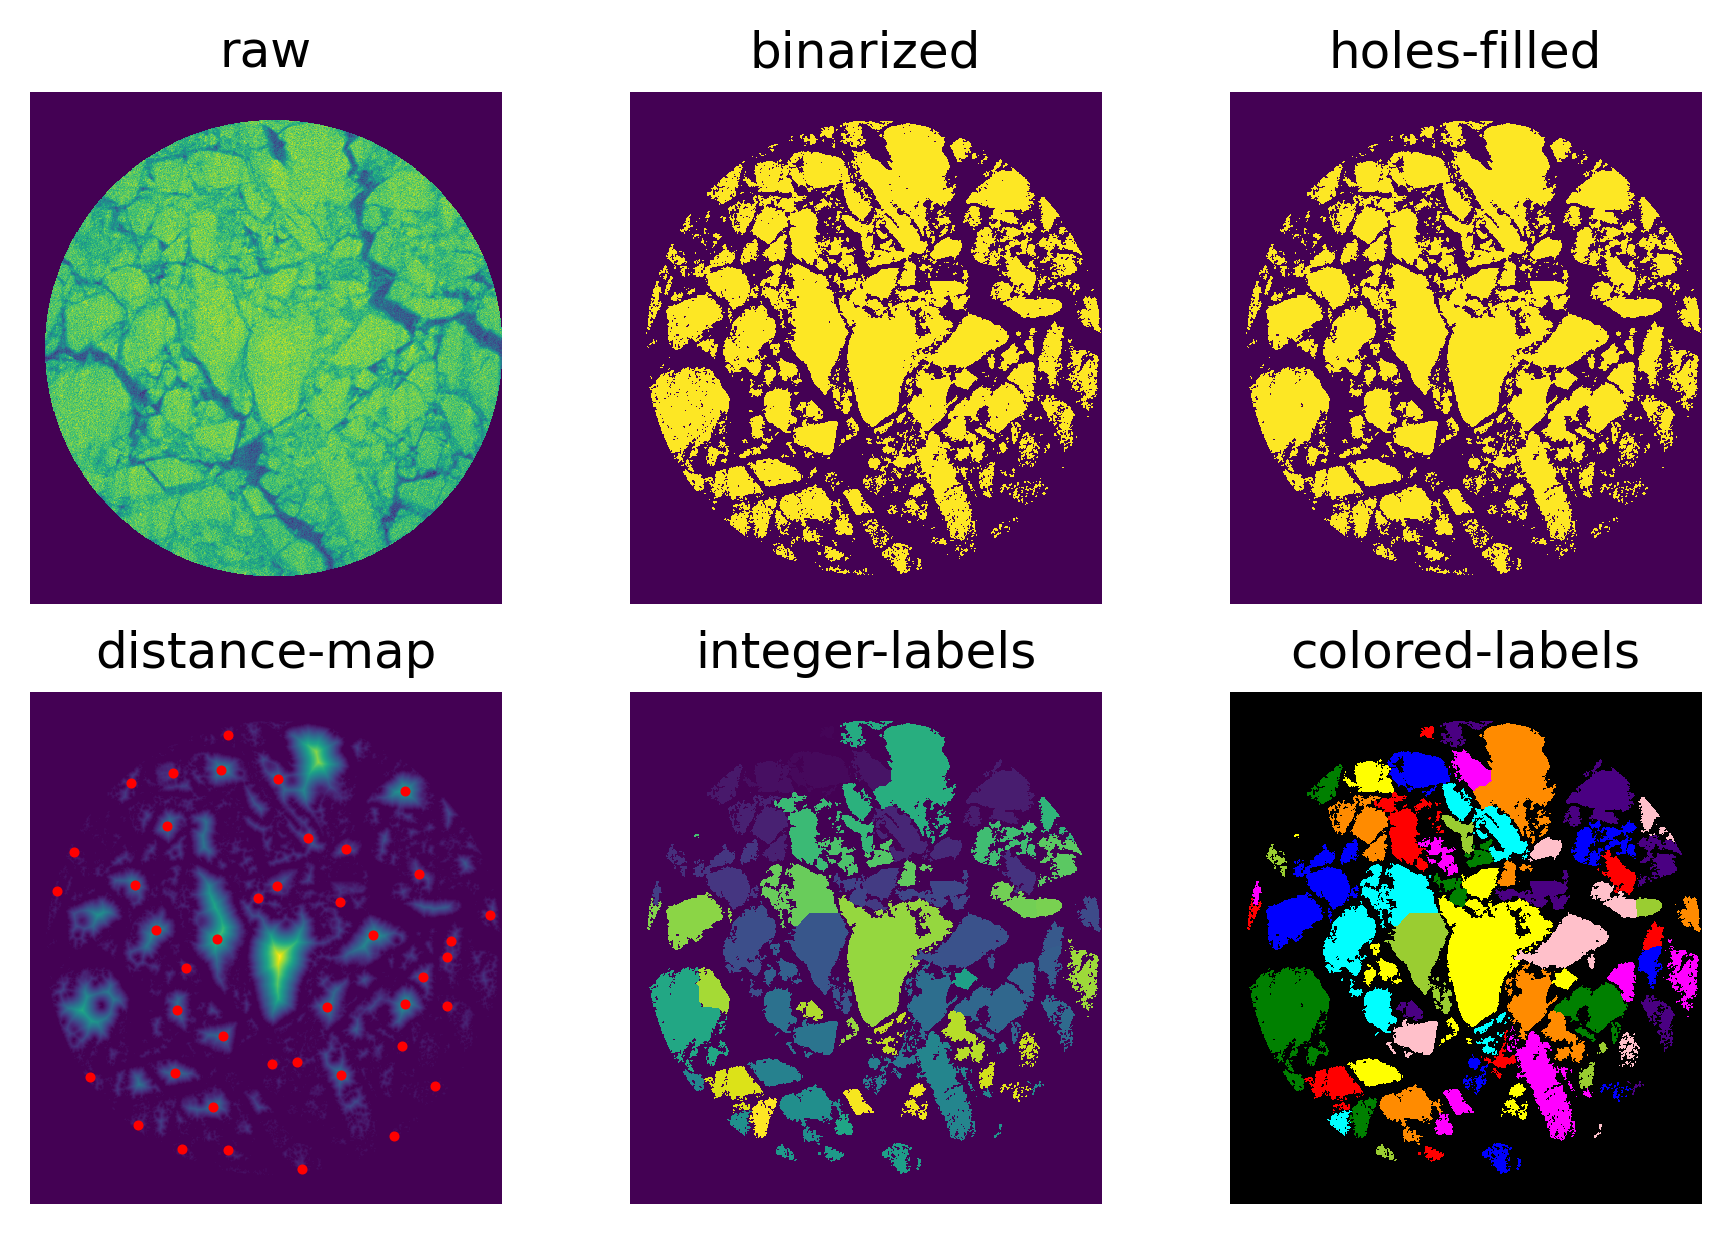

In [25]:
# Show process with napari
if use_napari:
    # Open napari viewer
    viewer = napari.Viewer()
    # Add raw images to napari window
    viewer.add_image(imgs, name='raw')
    for key, value in binarize_3d_dict.items():
        viewer.add_image(value, name=key)
    for key, value in segment_3d_dict.items():
        # Add arrays to napari window if they match the slice/row/col of imgs
        if isinstance(value, np.ndarray) and value.shape[:3] == imgs.shape:
            viewer.add_image(value, name=key)
        elif key == 'maxima-points':
            viewer.add_points(
                value, name=key, size=5, face_color='red', 
                edge_color='transparent'
            )
# Show process with matplotlib (use single image index, img_idx)
img_idx = 0
fig, axes = watershed.plot_process(
    img_idx, imgs, binarize_3d_dict, segment_3d_dict
)
plt.show()

# Plot comparison

Images binarized. Process steps: ['binarized', 'holes-filled']
Images segmented. Process steps: ['distance-map', 'maxima-points', 'maxima-mask', 'seeds', 'integer-labels', 'colored-labels']


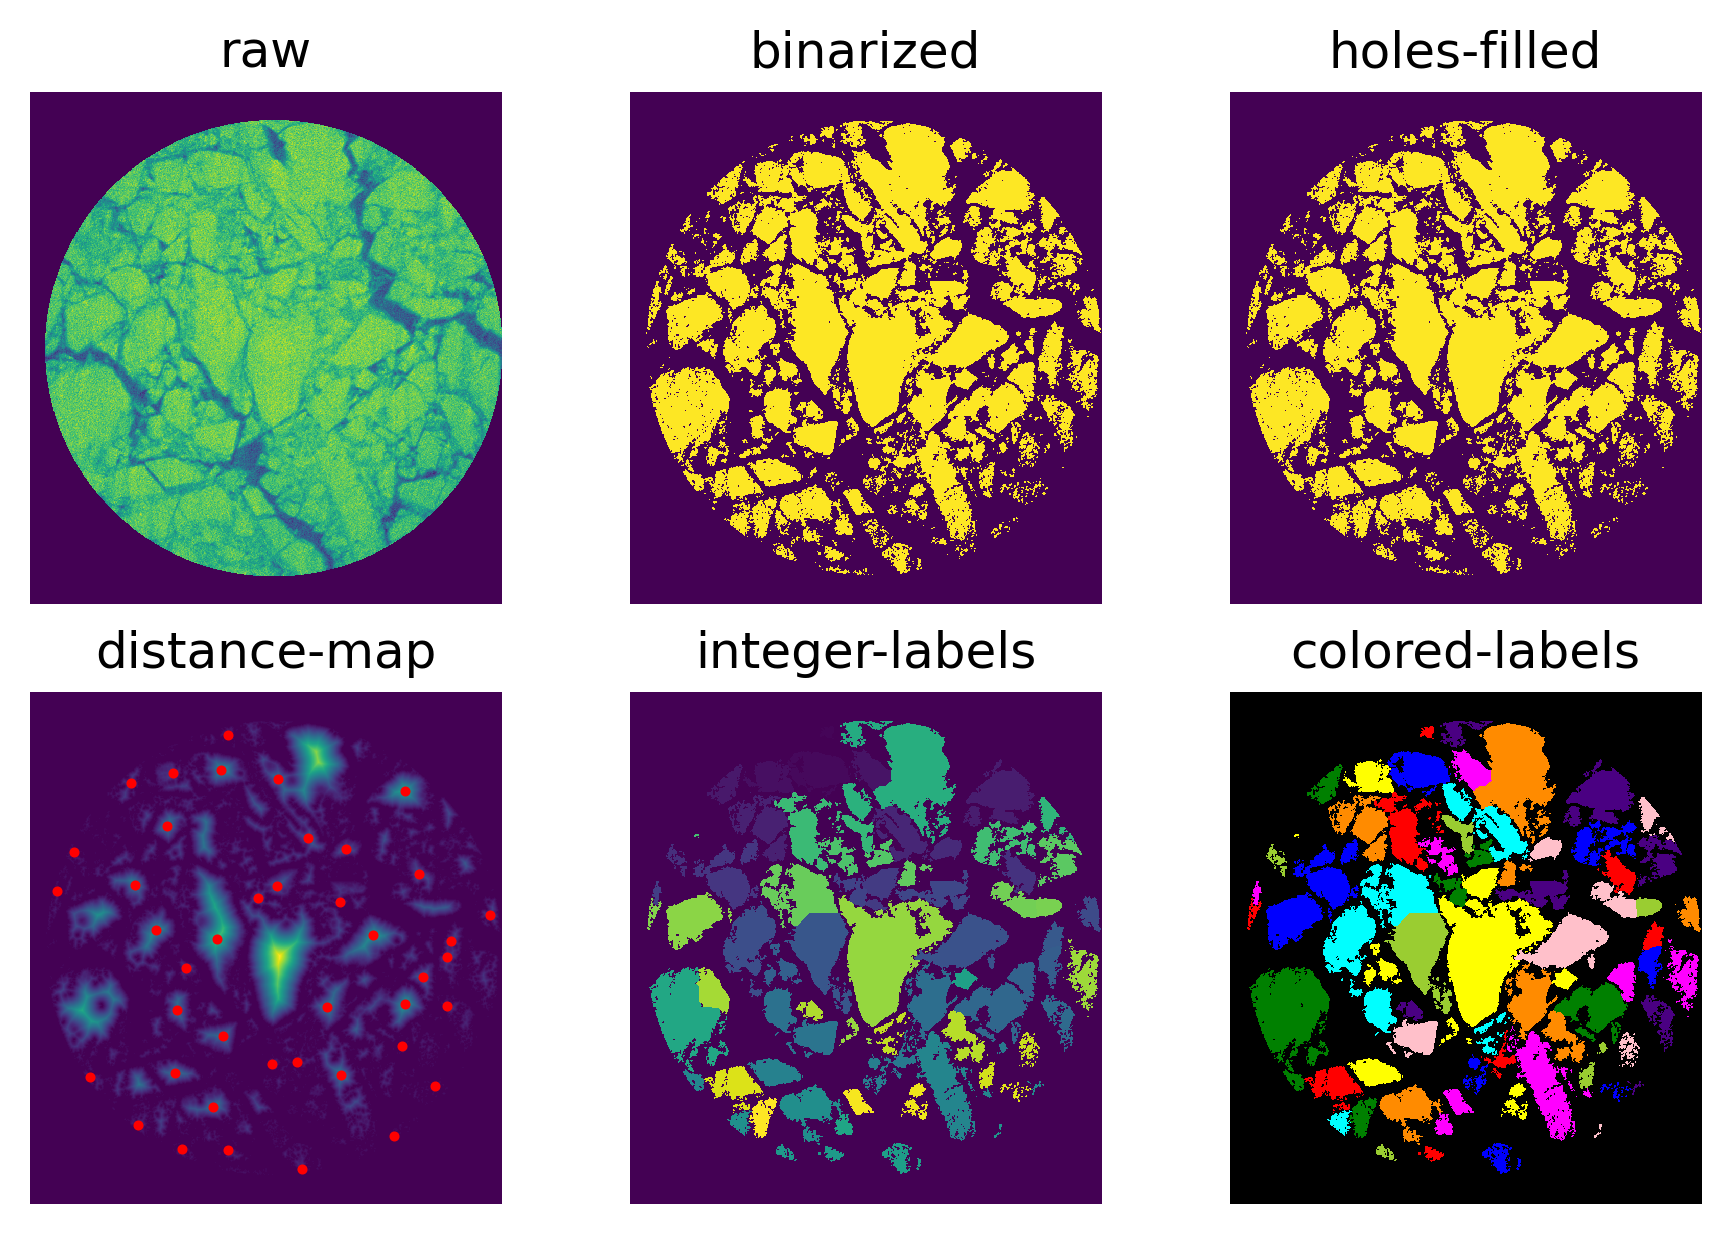

In [28]:
# Binarize raw images
binarize_3d_no_holes = watershed.binarize_3d(
    imgs, 
    thresh_val=0.65,
    fill_holes='all',
    return_process_dict=True
)
print(f'Images binarized. Process steps: {[key for key in binarize_3d_dict.keys()]}')
# Segment binary images with small holes filled
segment_3d_no_holes = watershed.segment_3d(
    binarize_3d_dict['holes-filled'],
    min_peak_distance=30,
    return_process_dict=True
)
print(f'Images segmented. Process steps: {[key for key in segment_3d_dict.keys()]}')
# Plot process
img_idx = 0
fig, axes = watershed.plot_process(
    img_idx, imgs, binarize_3d_no_holes, segment_3d_dict
)
plt.show()

In [29]:
# Show process with napari
if use_napari:
    # Add raw images to napari window
    viewer.add_image(imgs, name='raw')
    for key, value in binarize_3d_no_holes.items():
        viewer.add_image(value, name=key)
    for key, value in segment_3d_no_holes.items():
        # Add arrays to napari window if they match the slice/row/col of imgs
        if isinstance(value, np.ndarray) and value.shape[:3] == imgs.shape:
            viewer.add_image(value, name=key)
        elif key == 'maxima-points':
            viewer.add_points(
                value, name=key, size=5, face_color='red', 
                edge_color='transparent'
            )

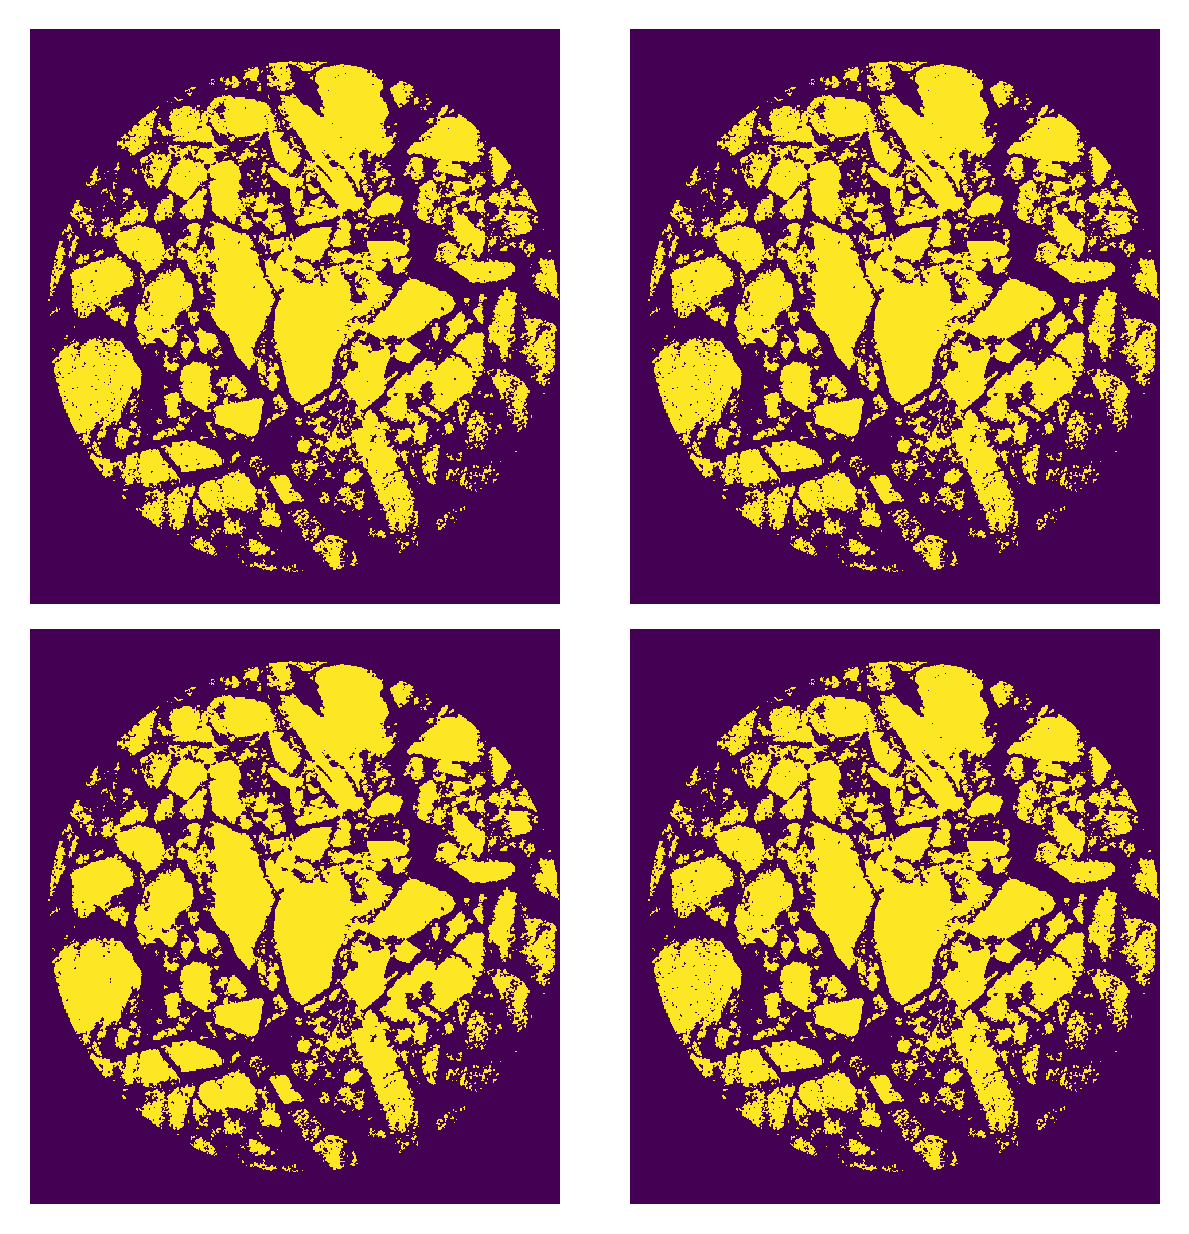

In [23]:
fig, axes = watershed.plot_comparison(img_idx, binarize_3d_dict, binarize_3d_no_holes)
plt.show()

## Save/load integer labels

In [5]:
watershed.save_images(
    segment_3d_dict['integer-labels'], 
    'segmented-integer-labels', 
    convert_to_16bit=True
)

10 image(s) saved to: C:\Users\gusb\Research\PSAAP\share\ct-segment-python\segmented-integer-labels


integer_labeled.shape=(10, 1004, 924)
integer_labeled.dtype=dtype('uint16')
integer_labeled.min()=0
integer_labeled.max()=75


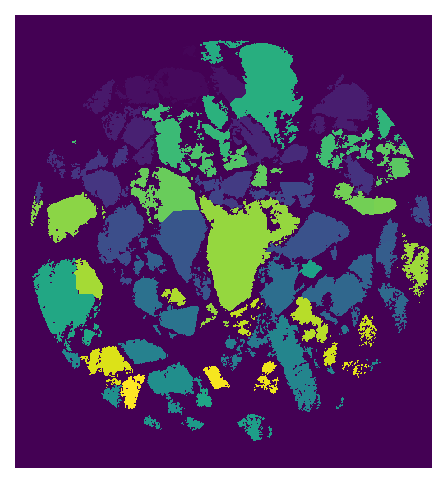

In [13]:
integer_labeled = watershed.load_images(
    'segmented-integer-labels', 
    return_3d_array=True, 
    convert_to_float=False
)
# Print loaded image details
print(f'{integer_labeled.shape=}')
print(f'{integer_labeled.dtype=}')
print(f'{integer_labeled.min()=}')
print(f'{integer_labeled.max()=}')
# Plot loaded image
fig, ax = plt.subplots(dpi=150)
ax.imshow(integer_labeled[0], interpolation='nearest')
ax.set_axis_off()
plt.show()

## Save/load colored labels

In [8]:
watershed.save_images(
    segment_3d_dict['colored-labels'], 
    'segmented-colored-labels', 
    convert_to_16bit=False
)

10 image(s) saved to: C:\Users\gusb\Research\PSAAP\share\ct-segment-python\segmented-colored-labels


color_labeled.shape=(10, 1004, 924, 3)
color_labeled.dtype=dtype('uint8')
color_labeled.min()=0
color_labeled.max()=255


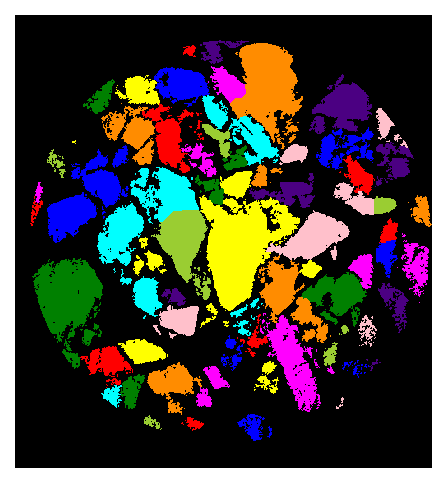

In [14]:
color_labeled = watershed.load_images(
    'segmented-colored-labels', 
    return_3d_array=True, 
    convert_to_float=False,
    file_suffix='png'
)
# Print loaded iamge details
print(f'{color_labeled.shape=}')
print(f'{color_labeled.dtype=}')
print(f'{color_labeled.min()=}')
print(f'{color_labeled.max()=}')
# Plot loaded image
fig, ax = plt.subplots(dpi=150)
ax.imshow(color_labeled[0], interpolation='nearest')
ax.set_axis_off()
plt.show()